=== Omnibus Test ===
Kruskal-Wallis H = 12.50, p = 0.0059
Effect size (ε²) = 0.008

=== Post-hoc Pairwise Comparisons ===
              Group 1                 Group 2  U Statistic  Raw p-value  Cliff's Delta  Adj. p-value Sig.
 Lack Of Availability         Incompatibility      82598.0       0.7452        -0.0141        1.0000     
 Lack Of Availability   Scheduled Termination      25789.5       0.0029        -0.1928        0.0171  ***
 Lack Of Availability Unfit For Participation     174502.5       0.2525         0.0392        1.0000     
      Incompatibility   Scheduled Termination       8664.5       0.0102        -0.1841        0.0611    *
      Incompatibility Unfit For Participation      58889.0       0.2316         0.0551        1.0000     
Scheduled Termination Unfit For Participation      26239.5       0.0005         0.2328        0.0028  ***


C:\Users\wzhon\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wzhon\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wzhon\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wzhon\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

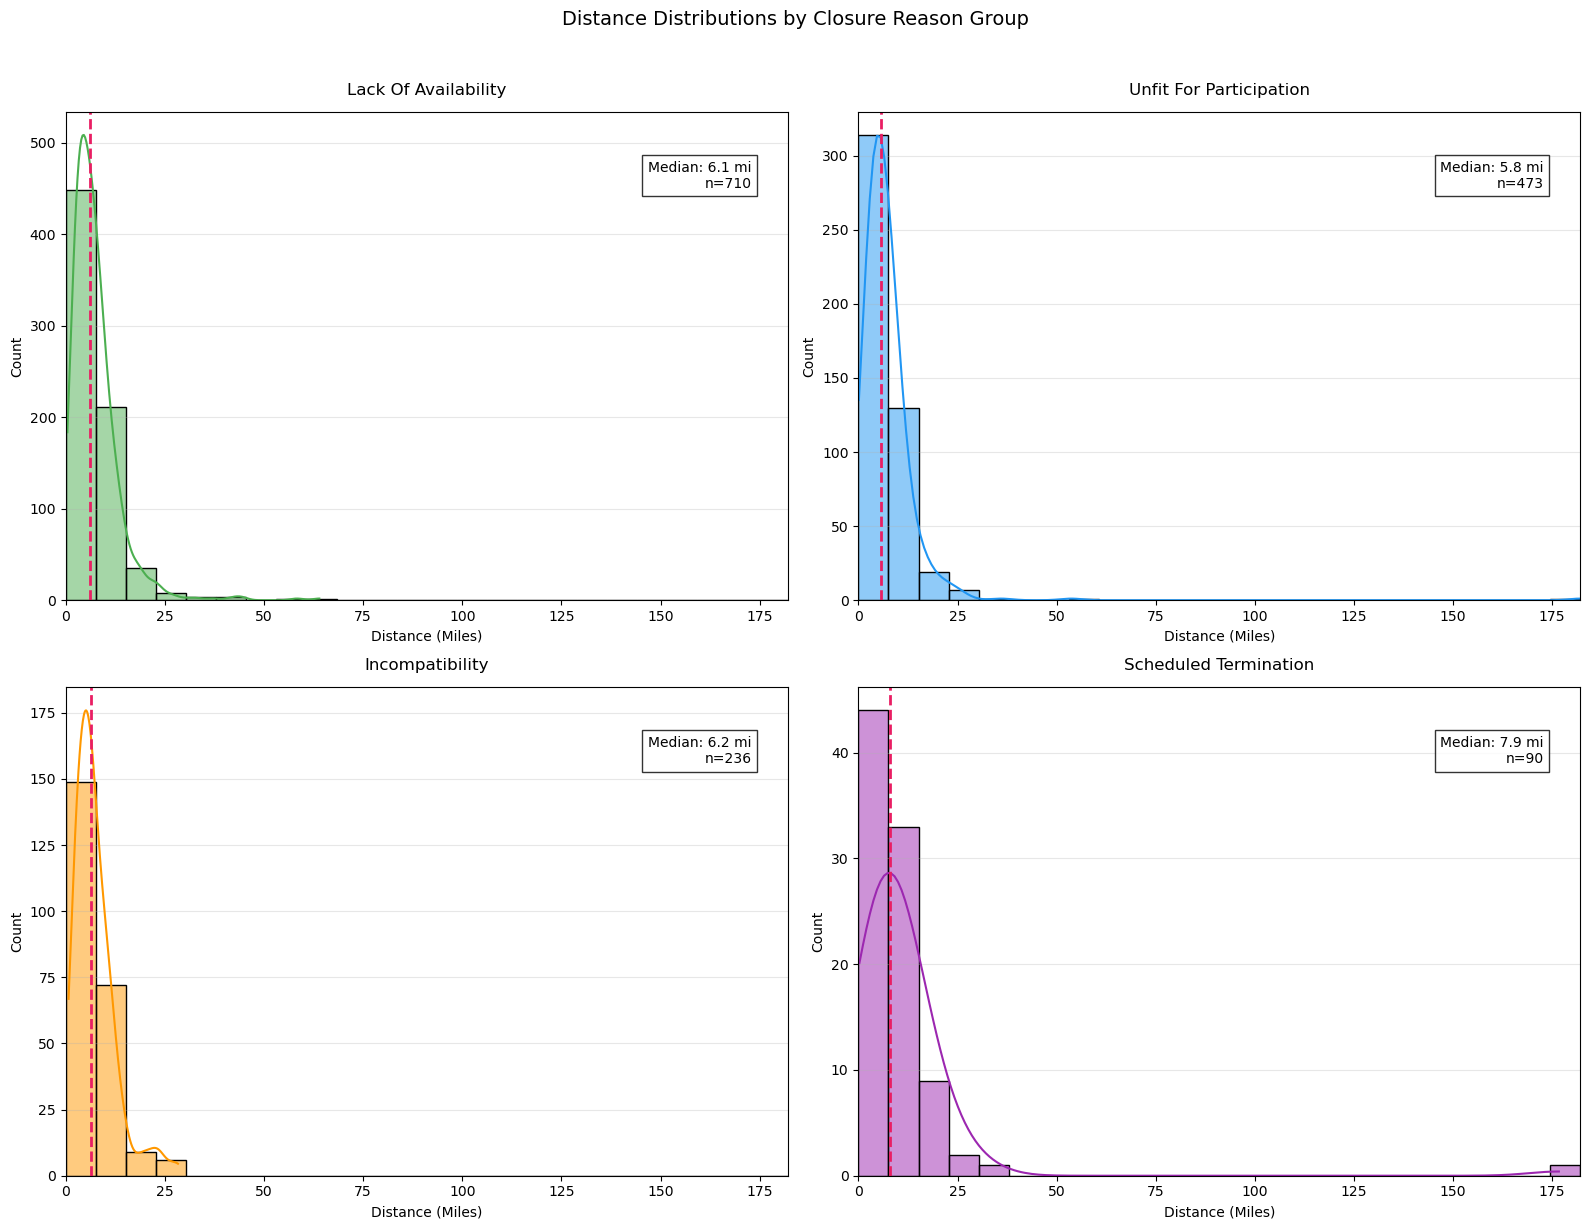

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# Load and clean data
df = pd.read_csv('results1.csv')
filtered_df = df[
    (df['Distance'].notna()) &
    (df['closure_reason_grp'].notna()) &
    (df['closure_reason_grp'] != '')
].copy()

# Convert to numeric and clean
filtered_df['Distance'] = pd.to_numeric(filtered_df['Distance'], errors='coerce')
filtered_df = filtered_df[filtered_df['Distance'] > 0]
filtered_df['closure_reason_grp'] = filtered_df['closure_reason_grp'].str.title()

# Get closure reasons with sufficient data (>20 observations)
reason_counts = filtered_df['closure_reason_grp'].value_counts()
valid_reasons = reason_counts[reason_counts > 20].index
filtered_df = filtered_df[filtered_df['closure_reason_grp'].isin(valid_reasons)]

# 1. Kruskal-Wallis Test (Omnibus Test)
groups = [group['Distance'].values 
          for name, group in filtered_df.groupby('closure_reason_grp')]
H, p_kw = kruskal(*groups)

print("=== Omnibus Test ===")
print(f"Kruskal-Wallis H = {H:.2f}, p = {p_kw:.4f}")
print(f"Effect size (ε²) = {H/(len(filtered_df)-1):.3f}\n")

# 2. Post-hoc Pairwise Comparisons
if p_kw < 0.05:
    print("=== Post-hoc Pairwise Comparisons ===")
    
    # Generate all possible pairs
    reasons = filtered_df['closure_reason_grp'].unique()
    pairs = list(combinations(reasons, 2))
    
    # Perform tests and calculate effect sizes
    results = []
    for group1_name, group2_name in pairs:
        group1 = filtered_df[filtered_df['closure_reason_grp'] == group1_name]['Distance']
        group2 = filtered_df[filtered_df['closure_reason_grp'] == group2_name]['Distance']
        
        # Mann-Whitney U test
        stat, p = mannwhitneyu(group1, group2)
        
        # Cliff's Delta effect size
        def cliffs_delta(x, y):
            nx, ny = len(x), len(y)
            wins = sum(1 for a in x for b in y if a > b) - sum(1 for a in x for b in y if a < b)
            return wins / (nx * ny)
        d = cliffs_delta(group1, group2)
        
        results.append({
            'Group 1': group1_name,
            'Group 2': group2_name,
            'U Statistic': stat,
            'Raw p-value': p,
            "Cliff's Delta": d
        })
    
    # Create DataFrame and apply Bonferroni correction
    results_df = pd.DataFrame(results)
    results_df['Adj. p-value'] = multipletests(results_df['Raw p-value'], method='bonferroni')[1]
    results_df['Sig.'] = np.where(results_df['Adj. p-value'] < 0.05, '***', 
                                np.where(results_df['Raw p-value'] < 0.05, '*', ''))
    
    # Format output
    pd.set_option('display.width', 100)
    print(results_df.round(4).to_string(index=False))
    
top_reasons = filtered_df['closure_reason_grp'].value_counts().head(4).index
# Get top closure reasons (sorted by frequency)
top_reasons = filtered_df['closure_reason_grp'].value_counts().index.tolist()

# Create 2x2 grid for histograms
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Common bins for all histograms
max_distance = filtered_df['Distance'].max()
bins = np.linspace(0, max_distance, 25)

# Color palette
colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0']

# Plot each closure reason
for idx, (reason, color) in enumerate(zip(top_reasons[:4], colors)):
    ax = axes[idx]
    reason_df = filtered_df[filtered_df['closure_reason_grp'] == reason]
    
    # Plot histogram
    sns.histplot(
        data=reason_df,
        x='Distance',
        bins=bins,
        kde=True,
        color=color,
        edgecolor='black',
        line_kws={'lw': 1.5},
        ax=ax
    )
    
    # Add median line
    median = reason_df['Distance'].median()
    ax.axvline(median, color='#E91E63', linestyle='--', linewidth=2)
    
    # Add annotations
    ax.text(0.95, 0.90, 
            f'Median: {median:.1f} mi\nn={len(reason_df)}',
            transform=ax.transAxes,
            ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Format subplot
    ax.set_title(f'{reason}', pad=12, fontsize=12)
    ax.set_xlabel('Distance (Miles)', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_xlim(0, max_distance)
    ax.grid(axis='y', alpha=0.3)

# Remove empty subplots if less than 4 reasons
for ax in axes[len(top_reasons[:4]):]:
    ax.remove()

# Final formatting
plt.suptitle('Distance Distributions by Closure Reason Group', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()